# Exploratory Data Analysis (EDA)
## Crypto Volatility Detection Pipeline

This notebook explores the features and determines the volatility spike threshold.


In [15]:
import sys
from pathlib import Path

# Add parent directory to path
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load config
with open(project_root / 'config.yaml') as f:
    config = yaml.safe_load(f)

# Create reports directory if it doesn't exist
reports_dir = project_root / 'reports'
reports_dir.mkdir(exist_ok=True)
evidently_dir = reports_dir / 'evidently'
evidently_dir.mkdir(exist_ok=True)

print(f"Project root: {project_root}")
print(f"Reports directory: {reports_dir}")


Project root: /Users/saikarthik/cursor/crypto-volatility
Reports directory: /Users/saikarthik/cursor/crypto-volatility/reports


## 1. Load Features


In [16]:
# Load features
# Get the project root directory (parent of notebooks/)
project_root = Path().absolute().parent
features_dir = project_root / config['features']['data_dir']
features_path = features_dir / 'features.parquet'

print(f"Looking for features at: {features_path}")
print(f"Path exists: {features_path.exists()}")

if features_path.exists():
    df = pd.read_parquet(features_path)
    print(f"Loaded {len(df)} feature rows")
    print(f"Columns: {list(df.columns)}")
else:
    print(f"Features file not found: {features_path}")
    print("Please run the featurizer or replay script first.")
    # Check if directory exists
    if features_dir.exists():
        print(f"Directory exists. Files in {features_dir}:")
        for f in features_dir.glob("*.parquet"):
            print(f"  - {f.name}")
    df = None


Looking for features at: /Users/saikarthik/cursor/crypto-volatility/data/processed/features.parquet
Path exists: True
Loaded 38652 feature rows
Columns: ['timestamp', 'product_id', 'price', 'midprice', 'return_1s', 'return_5s', 'return_30s', 'return_60s', 'volatility', 'trade_intensity', 'spread_abs', 'spread_rel', 'order_book_imbalance', 'window_size', 'num_returns']


## 2. Data Overview


In [11]:
if df is not None:
    print(df.head())
    print("\n" + "="*60)
    print(df.info())
    print("\n" + "="*60)
    print(df.describe())


      timestamp product_id    price  midprice  return_1s  return_5s  \
0  1.763313e+09    ETH-USD  3057.30  3057.145   0.000000   0.000245   
1  1.763313e+09    ETH-USD  3057.30  3057.315   0.000056   0.000301   
2  1.763313e+09    ETH-USD  3057.38  3057.315   0.000000   0.000239   
3  1.763313e+09    ETH-USD  3057.38  3057.445   0.000043   0.000281   
4  1.763313e+09    ETH-USD  3057.44  3057.445   0.000000   0.000098   

   return_30s  return_60s  volatility  trade_intensity  spread_abs  \
0         0.0         0.0    0.000058         0.166667        0.01   
1         0.0         0.0    0.000056         0.183333        0.13   
2         0.0         0.0    0.000054         0.200000        0.13   
3         0.0         0.0    0.000052         0.216667        0.01   
4         0.0         0.0    0.000051         0.233333        0.01   

   spread_rel  order_book_imbalance  window_size  num_returns  
0    0.000003              0.000002           10            9  
1    0.000043           

## 3. Compute Future Volatility (Target Variable)

We need to compute the volatility over the next 60 seconds (prediction horizon) for each timestamp.


In [17]:
if df is not None:
    # Sort by timestamp
    df = df.sort_values('timestamp').reset_index(drop=True)

    # Convert timestamp to datetime if needed
    if df['timestamp'].dtype == 'float64':
        df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
    else:
        df['datetime'] = pd.to_datetime(df['timestamp'])

    # Compute future volatility (rolling std of returns over next 60 seconds)
    prediction_horizon = config['features']['prediction_horizon']  # 60 seconds

    # For each row, compute volatility of returns in the next 60 seconds
    future_volatility = []

    for idx in range(len(df)):
        current_time = df.loc[idx, 'timestamp']
        future_time = current_time + prediction_horizon

        # Find rows within the future window
        future_mask = (df['timestamp'] > current_time) & (df['timestamp'] <= future_time)
        future_returns = df.loc[future_mask, 'return_1s'].dropna()

        if len(future_returns) > 1:
            vol = future_returns.std()
        else:
            vol = np.nan

        future_volatility.append(vol)

    df['future_volatility'] = future_volatility

    print(f"Computed future volatility for {df['future_volatility'].notna().sum()} rows")
    print("Future volatility stats:")
    print(df['future_volatility'].describe())


Computed future volatility for 38636 rows
Future volatility stats:
count    38636.000000
mean         0.000072
std          0.000041
min          0.000000
25%          0.000036
50%          0.000070
75%          0.000092
max          0.000272
Name: future_volatility, dtype: float64


## 4. Volatility Distribution Analysis


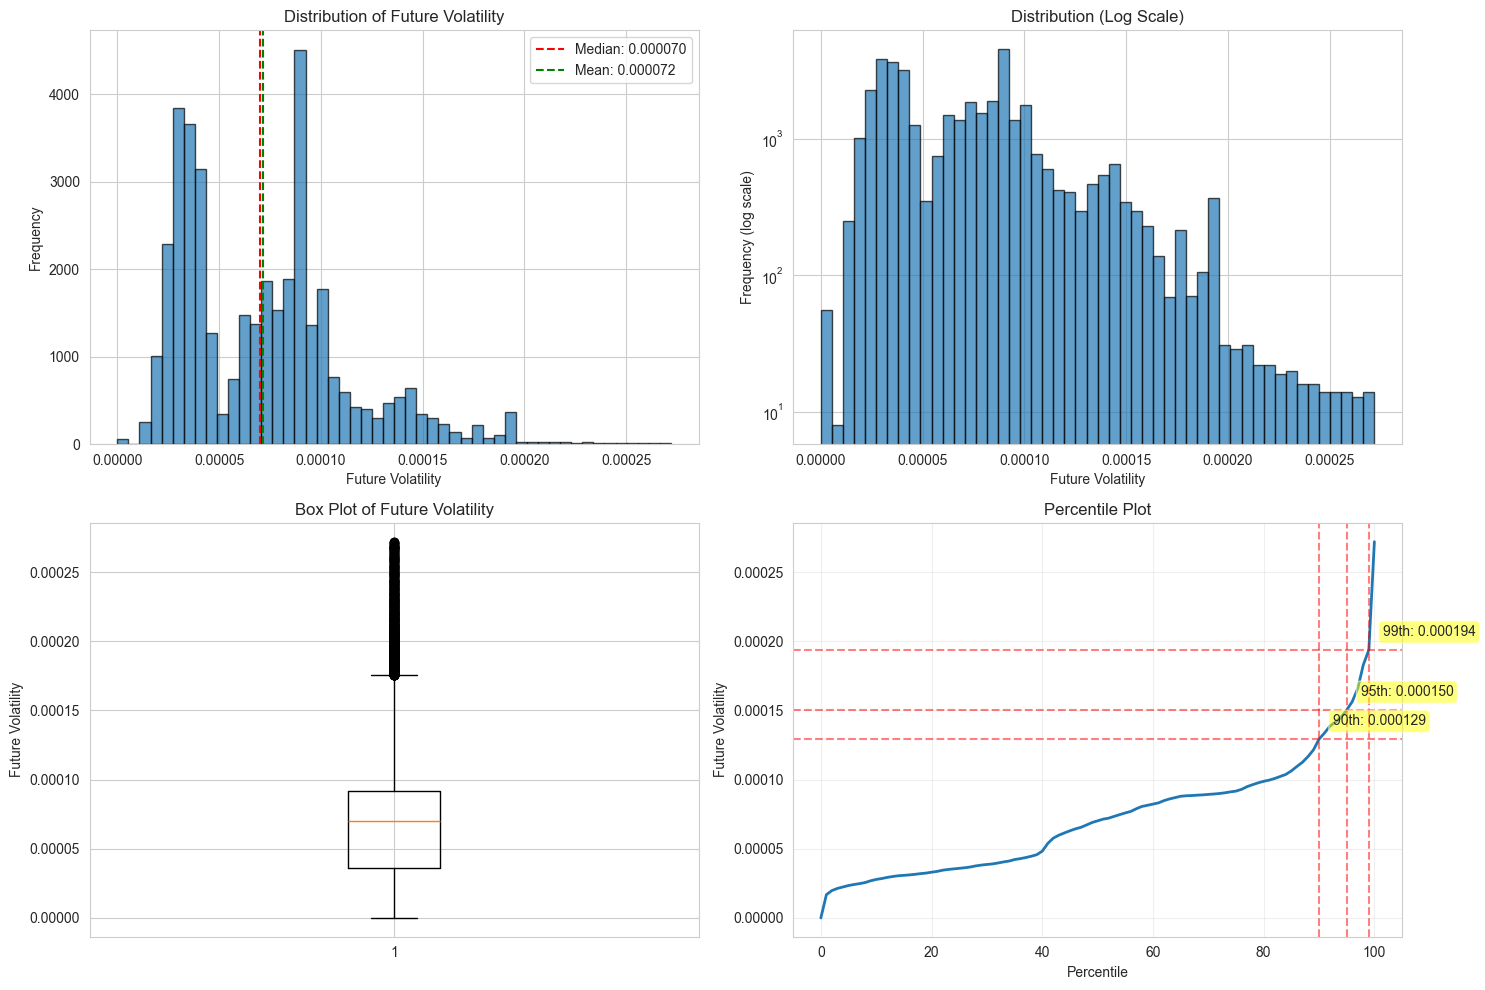


Percentile Statistics:
 50.0th percentile: 0.00007017
 75.0th percentile: 0.00009166
 90.0th percentile: 0.00012921
 95.0th percentile: 0.00015028
 97.5th percentile: 0.00017492
 99.0th percentile: 0.00019374
 99.5th percentile: 0.00021090
 99.9th percentile: 0.00025655


In [18]:
if df is not None and 'future_volatility' in df.columns:
    # Remove NaN values
    vol_data = df['future_volatility'].dropna()

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Histogram
    axes[0, 0].hist(vol_data, bins=50, edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Future Volatility')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Future Volatility')
    axes[0, 0].axvline(vol_data.median(), color='red', linestyle='--', label=f'Median: {vol_data.median():.6f}')
    axes[0, 0].axvline(vol_data.mean(), color='green', linestyle='--', label=f'Mean: {vol_data.mean():.6f}')
    axes[0, 0].legend()

    # Log scale histogram
    axes[0, 1].hist(vol_data, bins=50, edgecolor='black', alpha=0.7)
    axes[0, 1].set_yscale('log')
    axes[0, 1].set_xlabel('Future Volatility')
    axes[0, 1].set_ylabel('Frequency (log scale)')
    axes[0, 1].set_title('Distribution (Log Scale)')

    # Box plot
    axes[1, 0].boxplot(vol_data, vert=True)
    axes[1, 0].set_ylabel('Future Volatility')
    axes[1, 0].set_title('Box Plot of Future Volatility')

    # Percentile plot
    percentiles = np.arange(0, 101, 1)
    percentile_values = np.percentile(vol_data, percentiles)
    axes[1, 1].plot(percentiles, percentile_values, linewidth=2)
    axes[1, 1].set_xlabel('Percentile')
    axes[1, 1].set_ylabel('Future Volatility')
    axes[1, 1].set_title('Percentile Plot')
    axes[1, 1].grid(True, alpha=0.3)

    # Mark key percentiles
    for p in [90, 95, 99]:
        val = np.percentile(vol_data, p)
        axes[1, 1].axvline(p, color='red', linestyle='--', alpha=0.5)
        axes[1, 1].axhline(val, color='red', linestyle='--', alpha=0.5)
        axes[1, 1].annotate(f'{p}th: {val:.6f}', xy=(p, val),
                           xytext=(10, 10), textcoords='offset points',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

    plt.tight_layout()
    plt.savefig(reports_dir / 'volatility_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Print percentile statistics
    print("\n" + "="*60)
    print("Percentile Statistics:")
    print("="*60)
    for p in [50, 75, 90, 95, 97.5, 99, 99.5, 99.9]:
        val = np.percentile(vol_data, p)
        print(f"{p:5.1f}th percentile: {val:.8f}")


Threshold Options:
95th percentile     : 0.00015028 ( 1932 spikes, 5.00%)
97.5th percentile   : 0.00017492 (  967 spikes, 2.50%)
99th percentile     : 0.00019374 (  387 spikes, 1.00%)
2 std above mean    : 0.00015434 ( 1699 spikes, 4.40%)
3 std above mean    : 0.00019563 (  277 spikes, 0.72%)


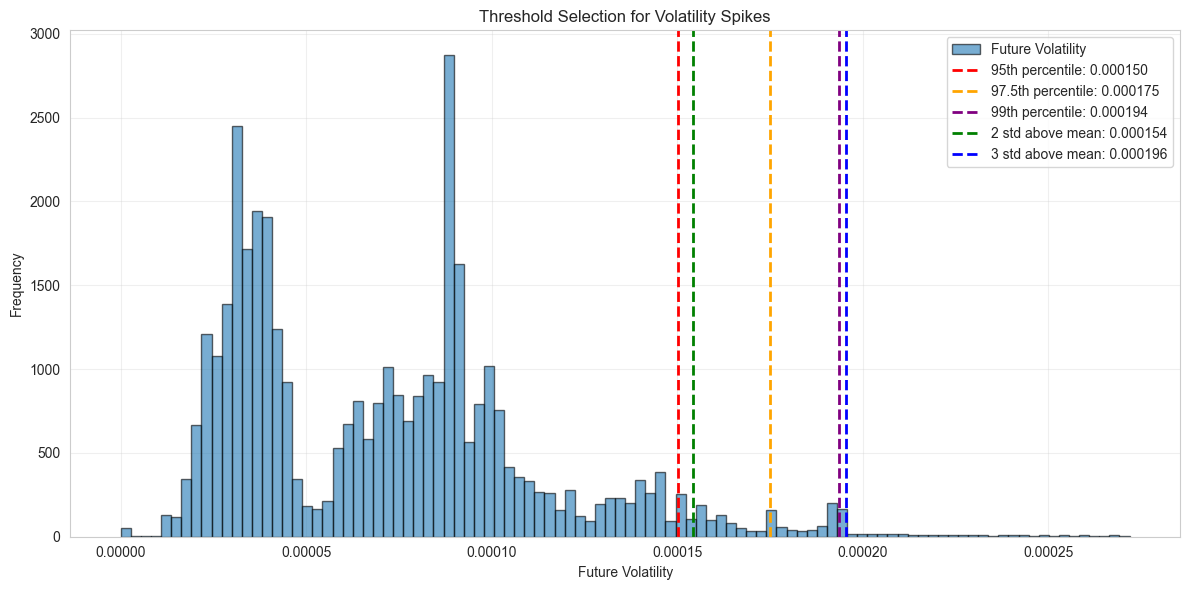


RECOMMENDED THRESHOLD (99th percentile): 0.00019374


In [19]:
if df is not None and 'future_volatility' in df.columns:
    vol_data = df['future_volatility'].dropna()

    # Calculate different threshold options
    thresholds = {
        '95th percentile': np.percentile(vol_data, 95),
        '97.5th percentile': np.percentile(vol_data, 97.5),
        '99th percentile': np.percentile(vol_data, 99),
        '2 std above mean': vol_data.mean() + 2 * vol_data.std(),
        '3 std above mean': vol_data.mean() + 3 * vol_data.std(),
    }

    print("Threshold Options:")
    print("="*60)
    for name, threshold in thresholds.items():
        spike_count = (vol_data >= threshold).sum()
        spike_rate = spike_count / len(vol_data) * 100
        print(f"{name:20s}: {threshold:.8f} ({spike_count:5d} spikes, {spike_rate:.2f}%)")

    # Visualize threshold selection
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot distribution
    ax.hist(vol_data, bins=100, edgecolor='black', alpha=0.6, label='Future Volatility')

    # Mark thresholds
    colors = ['red', 'orange', 'purple', 'green', 'blue']
    for i, (name, threshold) in enumerate(thresholds.items()):
        ax.axvline(threshold, color=colors[i % len(colors)], linestyle='--',
                  linewidth=2, label=f"{name}: {threshold:.6f}")

    ax.set_xlabel('Future Volatility')
    ax.set_ylabel('Frequency')
    ax.set_title('Threshold Selection for Volatility Spikes')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(reports_dir / 'threshold_selection.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Recommended threshold (99th percentile)
    recommended_threshold = np.percentile(vol_data, 99)
    print(f"\n{'='*60}")
    print(f"RECOMMENDED THRESHOLD (99th percentile): {recommended_threshold:.8f}")
    print(f"{'='*60}")
